### Блок тестовых вопросов

*Выбросы это*: 

1. Обычно подразумевают такие объекты, признак или таргет у которых сильно выбивается из общего распределения.
2. Та часть отложенной выборки, которая не участвует в процессе Кросс-Валидации.
3. Фичи, выбрасываемые регуляризацией во время обучения.
4. Методы отбора признаков, основанные на итеративном исключении фичей по очереди.



**Ответ: 1)** по определению

_______________________________________________________

*Выберите верное утверждение про счетчики*: 

1. Счетчики необходимо всегда зашумлять: при этом размах шума должен быть минимальным.
2. Иногда модели поверх счетчиков переобучаются, тогда их лучше пересчитывать по технологии, напоминающей кросс-валидацию.
3. Счетчики всегда стоит устанавливать такими, чтобы при их подсчете не использовалось таргетное значение самого объекта.
4. Нет верного утверждения.



**Ответ: 2)** И вправду, так как MeanTargetEncoding кодирует категории на основе таргетной переменной, модель может переобучиться, так как при создании фичи мы как бы подглядываем в переменную, которую хотим предсказывать. Поэтому следует использовать технологии, основанные на отложенной выборке, кросс-валидации или добавлении шума, чтобы, используя модель для новых данных, мы не подсматривали в распределение их таргета

_______________________________________________________

*Выберите верные утверждения про tf-idf*: 

1. Tf-idf переводит описание объекта в число.
2. Tf-idf переводит описание объекта в вектор.
3. Чем больше idf, тем важнее слово.
4. Чем меньше idf, тем важнее слово.
5. Перед применением tf-idf стоит воспользоваться технологией стемминга или лемматизации.


**Ответ: 2, 3, 5)** 2,3 По определению и формулам из лекции. 5, Стемминг и лемматизация и вправду важны для tf-idf, так как позволяют унифицировать слова по их основному значению
_______________________________________________________

### Блок практики

### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [1]:
import numpy as np
import pandas as pd

### Загрузим датасет

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [3]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

### Для этого можно воспользоваться следующей конструкцией:

data.isna().sum()

vendor_id                  0
passenger_count       145864
store_and_fwd_flag         0
distance_km           145864
log_trip_duration          0
anomaly                    0
traffic_jam                0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
hour_1                     0
hour_2                     0
hour_3                     0
hour_4                     0
hour_5                     0
hour_6                     0
hour_7                     0
hour_8                     0
hour_9                     0
hour_10                    0
hour_11                    0
hour_12                    0
hour_13                    0
hour_14                    0
hour_15                    0
hour_16                    0
hour_17                    0
hour_18                    0
hour_19                    0
hour_20                    0
hour_21                    0
hour_22       

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [4]:
data

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id2376096,1,NaN,0,1.226296,6.658011,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
id1049543,0,930.399753,0,6.056935,6.486161,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id2304944,1,930.399753,0,7.832952,6.639876,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
data.groupby('passenger_count', as_index=True).agg({'distance_km': 'count'}).sort_values('distance_km').max()

distance_km    837140
dtype: int64

In [6]:
data.groupby('passenger_count', as_index=False).size().sort_values('size')

,passenger_count,size
1,104.000000,1
2,560.000000,1
0,19.666667,3
9,1718.433333,57
6,1053.529749,25543
7,1061.355223,43460
5,1028.236276,53751
8,1070.232174,70348
4,1005.458335,189262
3,930.399753,930354


In [7]:
### Сгруппируем данные по passenger_count
### Аггрегируем по количеству вхождений в колонку

grouped = data.groupby('passenger_count', as_index=False).size().sort_values('size')

### Выберем самое популярное значение

most_recent = grouped['passenger_count'].values[-1]

### Заполним им пропуски

data.passenger_count = data.passenger_count.fillna(most_recent)

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [8]:
### Положим колонки, по которым сверяем похожесть объектов,
### в переменную cols_to_group

cols_to_group = ['vendor_id', 'store_and_fwd_flag', 'traffic_jam', 'month_2',
                 'month_3', 'month_4', 'month_5', 'month_6']

### Сгруппируем датасет по этим колонкам и посчитаем
### среднее значение таргета

mapping = data[~data.distance_km.isna()].groupby(cols_to_group)['distance_km'].mean()

mapping = mapping.reset_index()

### Замаппим объекты по группированным колонкам
### с полученным средним значением

merged = pd.merge(data,
                  mapping,
                  left_on=list(mapping.columns[:-1]),
                  right_on=list(mapping.columns[:-1]),
                  how='left')

### Заполним пропуски

merged['distance_km_x'] = merged['distance_km_x'].fillna(merged.distance_km_y)

### Дропнем дублированную колонку

data = merged.rename({'distance_km_x':'distance_km'}, axis=1).drop('distance_km_y', axis=1)

In [9]:
### Убедимся, что пропусков не осталось


data.isna().sum()

vendor_id             0
passenger_count       0
store_and_fwd_flag    0
distance_km           0
log_trip_duration     0
anomaly               0
traffic_jam           0
day_of_week_1         0
day_of_week_2         0
day_of_week_3         0
day_of_week_4         0
day_of_week_5         0
day_of_week_6         0
hour_1                0
hour_2                0
hour_3                0
hour_4                0
hour_5                0
hour_6                0
hour_7                0
hour_8                0
hour_9                0
hour_10               0
hour_11               0
hour_12               0
hour_13               0
hour_14               0
hour_15               0
hour_16               0
hour_17               0
hour_18               0
hour_19               0
hour_20               0
hour_21               0
hour_22               0
hour_23               0
month_2               0
month_3               0
month_4               0
month_5               0
month_6               0
dtype: int64

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [10]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

### Воспользуемся уже известной конструкцией с cross_validate

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

model = LinearRegression()

X = data.drop('log_trip_duration', axis=1)
Y = data['log_trip_duration']

cv_result_1 = cross_validate(model, X, Y, 
                             scoring='neg_mean_squared_error',
                             cv=selector, return_train_score=True)

cross_val_error = -np.mean(cv_result_1['test_score'])

print(f"RMSLE на Кросс-валидации: {round(cross_val_error, 3)}")

RMSLE на Кросс-валидации: 0.431


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

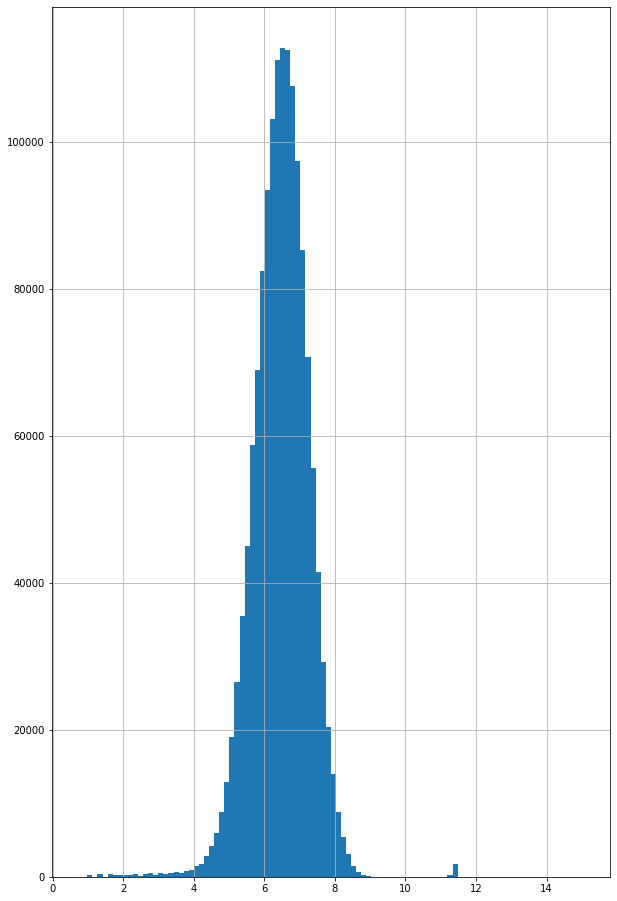

In [11]:
### Изобразим гистограмму через встроенный метод в пандасе

import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches((10, 16))

data["log_trip_duration"].hist(bins=100)

plt.show()

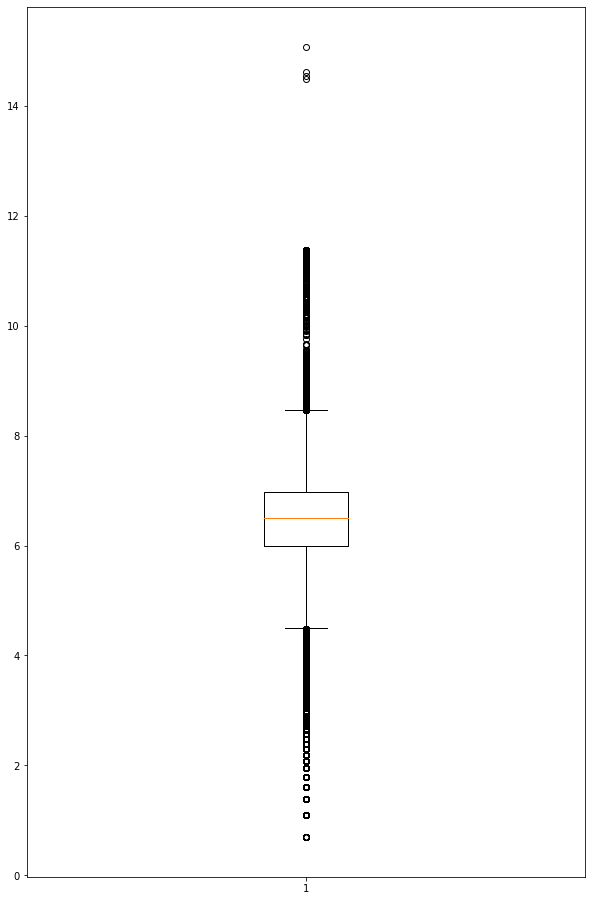

In [12]:
### А ящик с усами через функцию boxplot из pyplot

from matplotlib import pyplot as plt

fig = plt.figure()

fig.set_size_inches((10, 16))

plt.boxplot(data['log_trip_duration'].values)

plt.show()

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [13]:
### Сохраним топ99,5% и топ0,5% значения в переменные top05, top995

top05 = data.log_trip_duration.quantile(0.995)
top995 =  data.log_trip_duration.quantile(0.005)

### Удалим из датасета все объекты с таргетом вне
### полученных выше значений

data = data[(data.log_trip_duration < top05)&(data.log_trip_duration > top995)]

Снова замерьте качество на кросс-валидации, используя старый selector

In [14]:
### Повторим код с замером качества на полученном датасете

X = data.drop('log_trip_duration', axis=1)
Y = data['log_trip_duration']

cv_result_2 = cross_validate(model, X, Y, 
                             scoring='neg_mean_squared_error',
                             cv=selector, return_train_score=True)

cross_val_error_2 = -np.mean(cv_result_2['test_score'])

print(f"RMSLE на Кросс-валидации: {round(cross_val_error_2, 3)}")

RMSLE на Кросс-валидации: 0.35


Качество, несомненно, выросло! Это логично и будет наблюдатсья практически в любой задаче: нетипичные объекты всегда сложнее предсказывать, и ошибки на них оказываются больше, чем на "средних" объектах. Стоит, конечно же, понимать, что если в тренировочной выборке были выбросы, а в новых данных они ожидаются, то, выкинув выбросы из трейна, мы получим еще большие ошибки на новых выбросах. Поэтому с таким приемом следует быть аккуратным и задумываться: важно ли нам получать адекватные прогнозы на аномальных объектах?